In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/cleaned_data.csv")

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [5]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [6]:
rfm.shape

(4338, 3)

In [7]:
additional_features = df.groupby("CustomerID").agg({
    "StockCode": "nunique",
    "Quantity": "sum",
    "TotalPrice": "mean"
})

additional_features.columns = [
    "UniqueProducts",
    "TotalQuantity",
    "AvgOrderValue"
]

additional_features.head()

,UniqueProducts,TotalQuantity,AvgOrderValue
CustomerID,,,
12346.0,1,74215,77183.600000
12347.0,103,2458,23.681319
12348.0,22,2341,57.975484
12349.0,73,631,24.076027
12350.0,17,197,19.670588


In [8]:
|rfm = rfm.merge(additional_features, on="CustomerID")

rfm.head()

SyntaxError: invalid syntax (3838760811.py, line 1)

In [9]:
rfm = rfm.merge(additional_features, left_index=True, right_index=True)

rfm.head()

,Recency,Frequency,Monetary,UniqueProducts,TotalQuantity,AvgOrderValue
CustomerID,,,,,,
12346.0,326,1,77183.60,1,74215,77183.600000
12347.0,2,7,4310.00,103,2458,23.681319
12348.0,75,4,1797.24,22,2341,57.975484
12349.0,19,1,1757.55,73,631,24.076027
12350.0,310,1,334.40,17,197,19.670588


In [10]:
rfm.shape

(4338, 6)

In [11]:
import numpy as np

rfm_log = rfm.copy()

rfm_log["Monetary"] = np.log1p(rfm_log["Monetary"])
rfm_log["TotalQuantity"] = np.log1p(rfm_log["TotalQuantity"])
rfm_log["AvgOrderValue"] = np.log1p(rfm_log["AvgOrderValue"])

rfm_log.head()

,Recency,Frequency,Monetary,UniqueProducts,TotalQuantity,AvgOrderValue
CustomerID,,,,,,
12346.0,326,1,11.253955,1,11.214735,11.253955
12347.0,2,7,8.368925,103,7.807510,3.206047
12348.0,75,4,7.494564,22,7.758761,4.077122
12349.0,19,1,7.472245,73,6.448889,3.221912
12350.0,310,1,5.815324,17,5.288267,3.028712


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled[:5]

array([[ 2.33457414, -0.4250965 ,  3.70622476, -0.7088019 ,  3.81665325,
         9.64498596],
       [-0.90534032,  0.3544168 ,  1.41184341,  0.48618019,  1.32948521,
         0.26081225],
       [-0.17535959, -0.03533985,  0.7164889 , -0.46277618,  1.29389959,
         1.27651973],
       [-0.73534481, -0.4250965 ,  0.6987394 ,  0.13471487,  0.33773448,
         0.27931224],
       [ 2.17457836, -0.4250965 , -0.6189622 , -0.52135373, -0.50948367,
         0.05403299]])

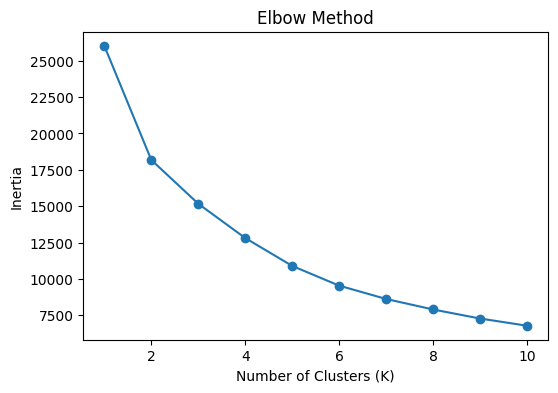

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1,11), inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,UniqueProducts,TotalQuantity,AvgOrderValue,Cluster
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,74215,77183.600000,1
12347.0,2,7,4310.00,103,2458,23.681319,1
12348.0,75,4,1797.24,22,2341,57.975484,1
12349.0,19,1,1757.55,73,631,24.076027,2
12350.0,310,1,334.40,17,197,19.670588,0


In [16]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(rfm_scaled, rfm["Cluster"])
db_score = davies_bouldin_score(rfm_scaled, rfm["Cluster"])

print("Silhouette Score:", sil_score)
print("Davies-Bouldin Index:", db_score)

Silhouette Score: 0.2842688812168022
Davies-Bouldin Index: 1.2026476708288696


In [17]:
rfm.skew()

Recency            1.246048
Frequency         12.067031
Monetary          19.324953
UniqueProducts     6.919445
TotalQuantity     20.359611
AvgOrderValue     46.496762
Cluster           -0.567543
dtype: float64

In [18]:
rfm_log = rfm.copy()

cols_to_log = [
    "Frequency",
    "Monetary",
    "UniqueProducts",
    "TotalQuantity",
    "AvgOrderValue"
]

for col in cols_to_log:
    rfm_log[col] = np.log1p(rfm_log[col])

rfm_log.head()

,Recency,Frequency,Monetary,UniqueProducts,TotalQuantity,AvgOrderValue,Cluster
CustomerID,,,,,,,
12346.0,326,0.693147,11.253955,0.693147,11.214735,11.253955,1
12347.0,2,2.079442,8.368925,4.644391,7.807510,3.206047,1
12348.0,75,1.609438,7.494564,3.135494,7.758761,4.077122,1
12349.0,19,0.693147,7.472245,4.304065,6.448889,3.221912,2
12350.0,310,0.693147,5.815324,2.890372,5.288267,3.028712,0


In [19]:
rfm_log.skew()

Recency           1.246048
Frequency         1.208652
Monetary          0.393553
UniqueProducts   -0.243262
TotalQuantity     0.040961
AvgOrderValue     1.593408
Cluster          -0.567543
dtype: float64

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log.drop(columns=["Cluster"], errors="ignore"))

rfm_scaled[:5]

array([[ 2.33457414, -0.95521426,  3.70622476, -2.52637584,  3.81665325,
         9.64498596],
       [-0.90534032,  1.07442519,  1.41184341,  0.96588114,  1.32948521,
         0.26081225],
       [-0.17535959,  0.38630445,  0.7164889 , -0.36773818,  1.29389959,
         1.27651973],
       [-0.73534481, -0.95521426,  0.6987394 ,  0.66508847,  0.33773448,
         0.27931224],
       [ 2.17457836, -0.95521426, -0.6189622 , -0.58438658, -0.50948367,
         0.05403299]])

In [21]:
rfm_log.to_csv("../data/processed/rfm_features.csv")